Jax 기반 1D FDM 모델 구현 기초

In [72]:
import json
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
from jax import lax
import pandas as pd
from scipy.optimize import curve_fit

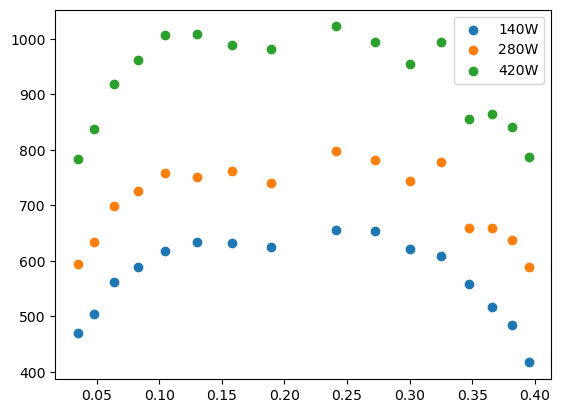

In [73]:
# temperature profile
tc_pos = json.load(open('tc_pos.json'))
T_140 = json.load(open('Temp_profile_140W.json'))
T_280 = json.load(open('Temp_profile_280W.json'))
T_420 = json.load(open('Temp_profile_420W.json'))

plt.scatter(tc_pos, T_140, label='140W')
plt.scatter(tc_pos, T_280, label='280W')
plt.scatter(tc_pos, T_420, label='420W')
plt.legend()
plt.show()

In [74]:
# Geometry
L = 430e-3 # reactor length [m]
ID = 5.03e-3 # inner diameter [m]
OD = 6.33e-3 # outer diameter [m]
tkn = OD - ID # wall thickness [m]

Ai = jnp.pi * ID**2 / 4 # inner cross-sectional area [m2]
Ao = jnp.pi * OD**2 / 4 # outer cross-sectional area [m2]
Aw = Ao - Ai # wall cross-sectional area [m2]

pri = jnp.pi * ID # inner perimeter [m]
pro = jnp.pi * OD # outer perimeter [m]

In [75]:
# Grid
dz = 0.001 # grid size [m]
n_nodes = int(L/dz) + 1 # number of grid points
z = jnp.linspace(0., L, n_nodes)

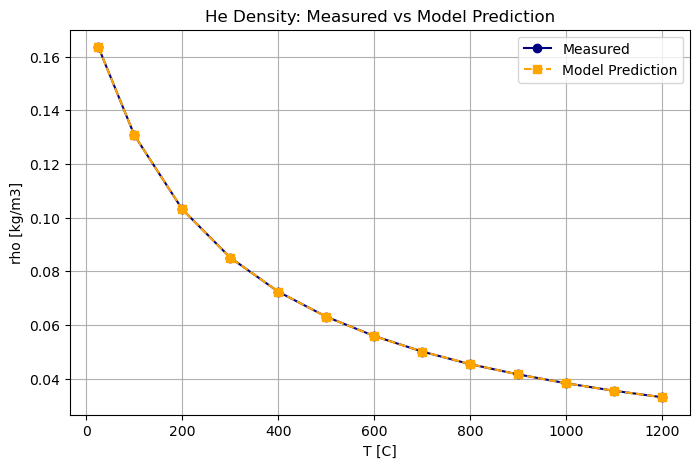

Text(0.5, 1.0, 'KanthalD Heat Capacity: Measured vs Model Prediction')

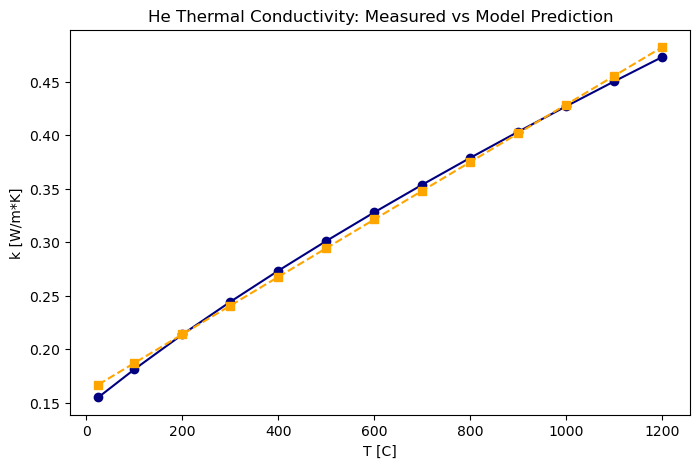

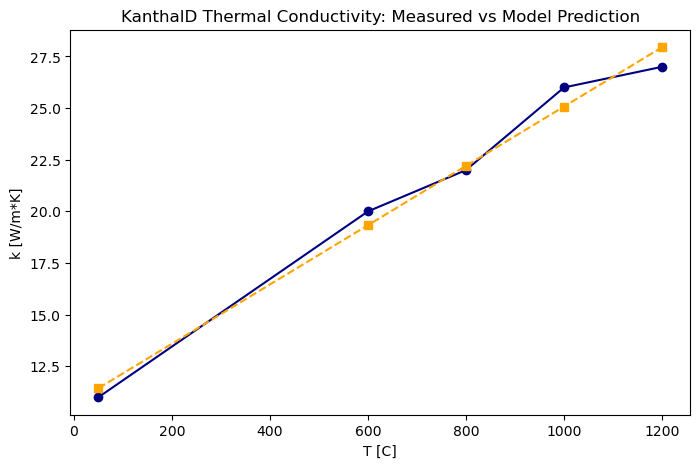

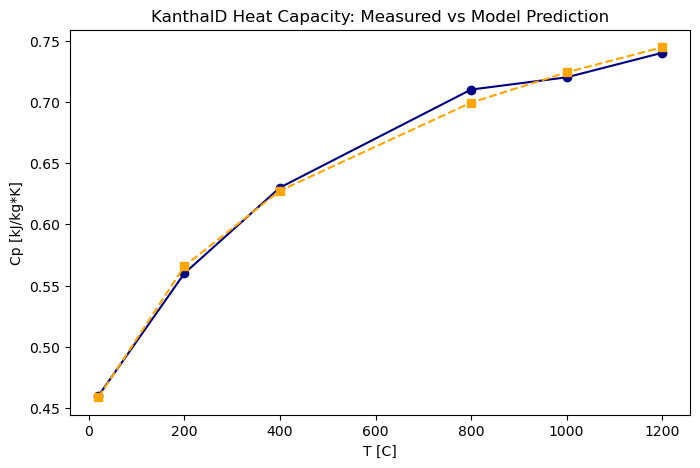

In [76]:
# Material properties
path_he = '../data/He_property.csv'
path_kt = '../data/KanthalD_property.csv'
df_he = pd.read_csv(path_he)
df_kt = pd.read_csv(path_kt)

# He molar weight
Mw_he = 4.0026 # g/mol

# He density
def rho_he_fit(T, a, b, c):
    return a / (b + T) + c
prho_he, _ = curve_fit(rho_he_fit, df_he['T [C]'], df_he['rho [kg/m3]'])
a_rho_he, b_rho_he, c_rho_he = prho_he
def rho_he(T):
    return a_rho_he / (b_rho_he + T) + c_rho_he
fitted_rho = rho_he(df_he['T [C]'])
plt.figure(figsize=(8,5))
plt.plot(df_he['T [C]'], df_he['rho [kg/m3]'], marker='o', linestyle='-', color='navy', label='Measured')
plt.plot(df_he['T [C]'], fitted_rho, marker='s', linestyle='--', color='orange', label='Model Prediction')
plt.xlabel('T [C]')
plt.ylabel('rho [kg/m3]')
plt.title('He Density: Measured vs Model Prediction')
plt.legend()
plt.grid(True)
plt.show()

# He heat capacity
Cp_he = 20.786 # J/mol/K, heat capacity of helium

# He thermal conductivity
def k_he_fit(T, a, b):
    return a*T + b
pk_he, _ = curve_fit(k_he_fit, df_he['T [C]'], df_he['Tc [W/m*K]'])
a_k_he, b_k_he = pk_he
def k_he(T):
    return a_k_he*T + b_k_he
fitted_k = k_he(df_he['T [C]'])
plt.figure(figsize=(8,5))
plt.plot(df_he['T [C]'], df_he['Tc [W/m*K]'], marker='o', linestyle='-', color='navy', label='Measured')
plt.plot(df_he['T [C]'], fitted_k, marker='s', linestyle='--', color='orange', label='Model Prediction')
plt.xlabel('T [C]')
plt.ylabel('k [W/m*K]')
plt.title('He Thermal Conductivity: Measured vs Model Prediction')

# kanthalD density
rho_kt = 7250 # kg/m3

# kanthalD thermal conductivity
def k_kt_fit(T, a, b):
    return a*T + b
df_kt_k = df_kt[df_kt['k [W/m*K]'].notna()]
pk_kt, _ = curve_fit(k_kt_fit, df_kt_k['T [C]'], df_kt_k['k [W/m*K]'])
a_k_kt, b_k_kt = pk_kt
def k_kt(T):
    return a_k_kt*T + b_k_kt
fitted_k_kt = k_kt(df_kt_k['T [C]'])
plt.figure(figsize=(8,5))
plt.plot(df_kt_k['T [C]'], df_kt_k['k [W/m*K]'], marker='o', linestyle='-', color='navy', label='Measured')
plt.plot(df_kt_k['T [C]'], fitted_k_kt, marker='s', linestyle='--', color='orange', label='Model Prediction')
plt.xlabel('T [C]')
plt.ylabel('k [W/m*K]')
plt.title('KanthalD Thermal Conductivity: Measured vs Model Prediction')

# kanthalD heat capacity
def Cp_kt_fit(T, a, b, c):
    return a*np.log(T + b) + c
df_kt_Cp = df_kt[df_kt['Cp [kJ/kg*K]'].notna()]
pk_kt, _ = curve_fit(Cp_kt_fit, df_kt_Cp['T [C]'], df_kt_Cp['Cp [kJ/kg*K]'])
a_Cp_kt, b_Cp_kt, c_Cp_kt = pk_kt
def Cp_kt(T):
    return (a_Cp_kt*jnp.log(T + b_Cp_kt) + c_Cp_kt) # kJ/kg/K
fitted_Cp_kt = Cp_kt(jnp.array(df_kt_Cp['T [C]']))
plt.figure(figsize=(8,5))
plt.plot(df_kt_Cp['T [C]'], df_kt_Cp['Cp [kJ/kg*K]'], marker='o', linestyle='-', color='navy', label='Measured')
plt.plot(df_kt_Cp['T [C]'], fitted_Cp_kt, marker='s', linestyle='--', color='orange', label='Model Prediction')
plt.xlabel('T [C]')
plt.ylabel('Cp [kJ/kg*K]')
plt.title('KanthalD Heat Capacity: Measured vs Model Prediction')

In [77]:
# Feed conditions
Fv_std = 50. # mL/min at standard conditions
Fw = Fv_std * 1e-6 / 60 * rho_he(0) # kg/s, feed mass flow rate
F = Fw / Mw_he * 1000 # mol/s, feed molar flow rate
P = 101325. # Pa, feed pressure
Tamb = 25.  # C, ambient temperature
Pw = 140. # W, electric power

In [78]:
# Energy Balance

Qelec = Pw * dz/L # W, heat generation per unit length
Awg = pri * dz # m2, heat transfer area per unit length
Aout = pro * dz # m2, outer surface area per unit length
hout = 10 # W/m2/K, heat transfer coefficient

def residual(U):
    Tw = U[:n_nodes]
    Tg = U[n_nodes:]

    kw = k_kt(Tw)
    cpg = Cp_he
    kg = k_he(Tg)
    hwg = 4.36*k_he(Tg)/ID

    # residual variables
    rw = jnp.zeros((n_nodes,))
    rg = jnp.zeros((n_nodes,))

    # Dirichlet BC for Tw: Tw = Tamb
    rw = rw.at[0].set(Tw[0] - Tamb)
    rw = rw.at[-1].set(Tw[-1] - Tamb)

    # Interior for Tw
    # 0 = div + Qelec - Qwg - Qout
    kw_half = 0.5 * (kw[1:] + kw[:-1])
    wflux = kw_half * Aw * (Tw[1:] - Tw[:-1]) / dz
    Qcond = (wflux[1:] - wflux[:-1]) / dz
    Qwg = hwg[1:-1] * Awg * (Tw[1:-1] - Tg[1:-1])
    Qout = hout * Aout * (Tw[1:-1] - Tamb)
    
    rw = rw.at[1:-1].set(Qcond + Qelec/dz - Qwg/dz - Qout/dz)

    # Dirichlet BC for Tg: Tg = Tamb
    rg = rg.at[0].set(Tg[0] - Tamb)
    rg = rg.at[-1].set(Tg[-1] - Tamb)

    # Interior for Tg
    # 0 = Qwg - F * Cp_he * dTg/dx
    gflux = F * cpg * (Tg[1:-1] - Tg[:-2]) / dz
    rg = rg.at[1:-1].set(Qwg/dz - gflux)
    
    return jnp.concatenate([rw, rg])


    

In [79]:
def newton_solve(U0, iters=20, damping=1.0, rtol=1e-6, atol=1e-9, verbose=True):
    U = U0
    res_hist = []
    step_hist = []

    for k in range(iters):
        F = residual(U)
        res_norm = jnp.linalg.norm(F)
        res_hist.append(res_norm)

        J = jax.jacfwd(residual)(U)
        dU = jnp.linalg.solve(J, -F)
        step_norm = jnp.linalg.norm(dU)
        step_hist.append(step_norm)

        U = U + damping * dU

        if verbose:
            print(f"[{k:02d}] ||F||={res_norm:.3e}, ||dU||={step_norm:.3e}")

        if res_norm < atol or res_norm < rtol * (1.0 + res_hist[0]):
            break

    return U, jnp.array(res_hist), jnp.array(step_hist)

In [80]:
Tw0 = Tamb * jnp.ones(n_nodes)
Tg0 = Tamb * jnp.ones(n_nodes)
U0 = jnp.concatenate([Tw0, Tg0])

[00] ||F||=6.744e+03, ||dU||=4.352e+04
[01] ||F||=1.953e+03, ||dU||=2.141e+03
[02] ||F||=5.431e+01, ||dU||=2.858e+01
[03] ||F||=6.847e-01, ||dU||=1.084e-02
[04] ||F||=6.565e-01, ||dU||=1.044e-03
[05] ||F||=6.521e-01, ||dU||=1.019e-03
[06] ||F||=6.677e-01, ||dU||=1.015e-03
[07] ||F||=6.580e-01, ||dU||=1.012e-03
[08] ||F||=6.760e-01, ||dU||=1.013e-03
[09] ||F||=6.675e-01, ||dU||=1.013e-03
[10] ||F||=6.823e-01, ||dU||=1.012e-03
[11] ||F||=6.580e-01, ||dU||=1.012e-03
[12] ||F||=6.760e-01, ||dU||=1.013e-03
[13] ||F||=6.675e-01, ||dU||=1.013e-03
[14] ||F||=6.823e-01, ||dU||=1.012e-03
[15] ||F||=6.580e-01, ||dU||=1.012e-03
[16] ||F||=6.760e-01, ||dU||=1.013e-03
[17] ||F||=6.675e-01, ||dU||=1.013e-03
[18] ||F||=6.823e-01, ||dU||=1.012e-03
[19] ||F||=6.580e-01, ||dU||=1.012e-03


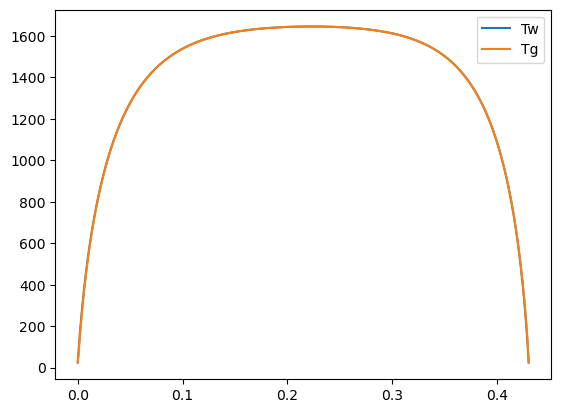

In [81]:
U, res_hist, step_hist = newton_solve(U0, iters=20, damping=1.0)

Tw = U[:n_nodes]
Tg = U[n_nodes:]

plt.plot(z, Tw, label='Tw')
plt.plot(z, Tg, label='Tg')
plt.legend()
plt.show()


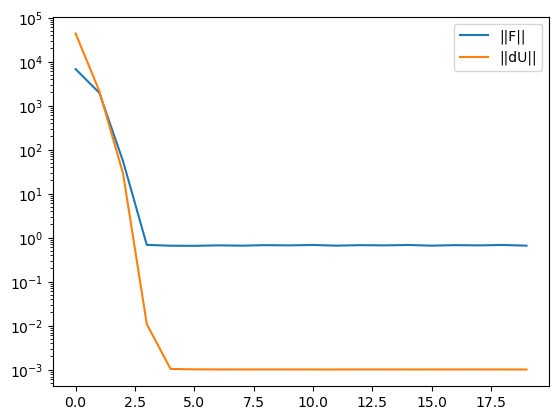

In [82]:
plt.semilogy(res_hist, label="||F||")
plt.semilogy(step_hist, label="||dU||")
plt.legend()
plt.show()